[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/03_raster_zonal_stats.ipynb)

In [1]:
#| default_exp raster_zonal_stats

In [2]:
#| include: false
#| no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [3]:
#| include: false
#| no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
#| include: false
#| no_test
!mkdir -p ../data
# download sample geojson files from repo
![ ! -e ../data/sample_terrain.tif ] && curl -s -o ../data/sample_terrain.tif https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/sample_terrain.tif
![ ! -e ../data/region3_admin.geojson ] && curl -s -o ../data/region3_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin.geojson
# originally from https://data.worldpop.org/GIS/Population/Global_2000_2020_Constrained/2020/BSGM/PHL/phl_ppp_2020_constrained.tif
![ ! -e ../data/phl_ppp_2020_constrained.tif ] && curl -s -o ../data/phl_ppp_2020_constrained.tif https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/phl_ppp_2020_constrained.tif

In [5]:
#| include: false
#| no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Note: This module is a thin layer on top of the `rasterstats` and `exactextract` packages to make its interface more compatible with the other geowrangler modules (e.g. vector zonal stats)

In [6]:
#| export
from pathlib import Path
from typing import Any, Dict, Union, List
import warnings
import json

import geopandas as gpd
import pandas as pd
import rasterio
import rasterstats as rs
from exactextract import exact_extract
from exactextract.raster import RasterioRasterSource

from geowrangler.vector_zonal_stats import _expand_aggs, _fillnas, _fix_agg

In [7]:
#| export
def create_raster_zonal_stats(
    aoi: Union[  # The area of interest geodataframe, or path to the vector file
        str, gpd.GeoDataFrame
    ],
    data: Union[str, Path],  # The path to the raster data file
    aggregation: Dict[  # A dict specifying the aggregation. See `create_zonal_stats` from the `geowrangler.vector_zonal_stats` module for more details
        str, Any
    ],
    extra_args: Dict[  # Extra arguments passed to `rasterstats.zonal_stats` method
        str, Any
    ] = dict(
        layer=0,
        band_num=1,
        nodata=None,
        affine=None,
        all_touched=False,
    ),
) -> gpd.GeoDataFrame:

    """Compute zonal stats with a vector areas of interest (aoi) from raster data sources.
    This is a thin layer  over the `zonal_stats` method from
    the `rasterstats` python package for compatibility with other geowrangler modules.
    This method currently only supports 1 band for each call, so if you want to create zonal
    stats for multiple bands with the same raster data, you can call this method for
    each band (make sure to specify the correct `band_num` in the `extra_args` parameter).
    See https://pythonhosted.org/rasterstats/manual.html#zonal-statistics for more details"""
    fixed_agg = _fix_agg(aggregation)

    if "stats" in extra_args:
        extra_args.pop("stats")  # use aggregation

    if "geojson_out" in extra_args:
        extra_args.pop("geojson_out")  # never add features

    if "categorical" in extra_args:
        extra_args.pop("categorical")  # no use for categorical and categorical maps
    if "categorical_map" in extra_args:
        extra_args.pop("categorical_map")

    if "prefix" in extra_args:
        extra_args.pop("prefix")  # use agg['column'] as prefix

    if "add_stats" in extra_args:
        extra_args.pop("add_stats")  # always use stats only

    if "nodata" in extra_args:
        nodata = extra_args["nodata"]
        if nodata is None:
            extra_args.pop("nodata")
            with rasterio.open(data) as src:
                extra_args["nodata"] = src.nodata

    stats = fixed_agg["func"]
    prefix = fixed_agg["column"] + "_"

    renamed_columns = {
        f"{prefix}{func}": fixed_agg["output"][i]
        for (i, func) in enumerate(fixed_agg["func"])
        if f"{prefix}{func}" != fixed_agg["output"][i]
    }
    results_dict = rs.zonal_stats(
        vectors=aoi,
        raster=data,
        stats=stats,
        geojson_out=False,
        categorical=False,
        category_map=None,
        prefix=prefix,
        **extra_args,
    )

    results = pd.DataFrame.from_records(results_dict)
    results.rename(columns=renamed_columns, inplace=True)
    expanded_aggs = _expand_aggs([fixed_agg])

    if type(aoi) == str:
        aoi = gpd.read_file(aoi)

    _fillnas(expanded_aggs, results, aoi)

    aoi = aoi.merge(results, how="left", left_index=True, right_index=True)

    return aoi

In [8]:
#| include: false
# see tests/test_vector_zonal_stats.py
from shapely.geometry import Polygon

In [9]:
def make_simple_aoi():
    df = pd.DataFrame(
        data={
            "col1": [1, 2, 3],
            "lat0": [0.0, 1.0, 2.0],
            "lon0": [0.0, 0.0, 0.0],
            "lat1": [0.0, 1.0, 2.0],
            "lon1": [1.0, 1.0, 1.0],
            "lat2": [1.0, 2.0, 3.0],
            "lon2": [1.0, 1.0, 1.0],
            "lat3": [1.0, 2.0, 3.0],
            "lon3": [0.0, 0.0, 0.0],
        }
    )

    def square(row):
        return Polygon(
            (
                [
                    (row.lat0, row.lon0),
                    (row.lat1, row.lon1),
                    (row.lat2, row.lon2),
                    (row.lat3, row.lon3),
                ]
            )
        )

    return gpd.GeoDataFrame(df, geometry=df.apply(square, axis=1), crs="EPSG:3857") # Use 3857 to match terrain CRS


simple_aoi = make_simple_aoi()
terrain_file = "../data/sample_terrain.tif"

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio

In [11]:
with rasterio.open(terrain_file) as src:
    data = src.read(1)
    data_crs = src.crs
    data_bounds = src.bounds
print(data.shape, data_crs, data_bounds)

(707, 707) EPSG:3857 BoundingBox(left=-20.0, bottom=-19.994, right=19.994, top=20.0)


In [12]:
simple_aoi.total_bounds

array([0., 0., 3., 1.])

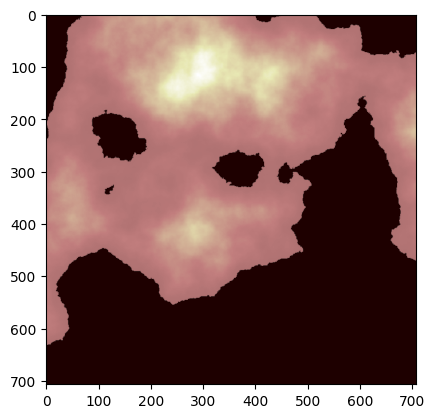

In [13]:
ax = plt.imshow(data, cmap="pink")

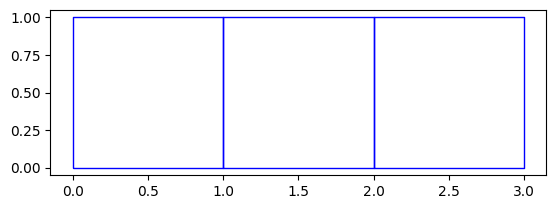

In [14]:
ax = simple_aoi.plot(facecolor="none", edgecolor="blue")

In [15]:
%%time
results = create_raster_zonal_stats(
    simple_aoi,
    terrain_file,
    aggregation=dict(func=["mean", "max", "min", "std"], column="elevation"),
    extra_args=dict(nodata=np.nan),
)

CPU times: user 32.8 ms, sys: 1.17 ms, total: 34 ms
Wall time: 33.2 ms


In [16]:
results

,col1,lat0,lon0,lat1,lon1,lat2,lon2,lat3,lon3,geometry,elevation_min,elevation_max,elevation_mean,elevation_std
0,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",1238.734161,1444.722213,1339.126726,64.362218
1,2,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",1222.409102,1425.920852,1311.903997,51.286449
2,3,2.0,0.0,2.0,1.0,3.0,1.0,3.0,0.0,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",1231.569771,1402.859628,1319.624868,45.298326


Check that `create_raster_zonal_stats` uses the `nodata` attribute set in the tif file if `extra_args.nodata` is set to `None`

In [17]:
# Load in admin bounds
phl_adm = gpd.read_file("../data/region3_admin.geojson")

If the `nodata` parameter is explicitly set to `-999999`, the Population count should be > 0.

In [18]:
grid_aoi_results = create_raster_zonal_stats(
    phl_adm,
    "../data/phl_ppp_2020_constrained.tif",
    aggregation=dict(
        func=["sum"],
        column="population",
        output=["population_count"],
        fillna=[True],
    ),
    extra_args=dict(nodata=-99999),
)

/home/jc_tm/project_repos/geowrangler/geowrangler/vector_zonal_stats.py:182: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results[colname].fillna(0, inplace=True)


In [19]:
grid_aoi_results

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,population_count
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",10983338.0


In [20]:
#| include: false
assert grid_aoi_results["population_count"].iloc[0] > 0

If  the `nodata` parameter is not set, `create_raster_zonal_stats` should use the `nodata` attribute set by the geotiff file so that population count should still be > 0.

In [21]:
grid_aoi_results = create_raster_zonal_stats(
    phl_adm,
    "../data/phl_ppp_2020_constrained.tif",
    aggregation=dict(
        func=["sum"],
        column="population",
        output=["population_count"],
        fillna=[True],
    ),
)

/home/jc_tm/project_repos/geowrangler/geowrangler/vector_zonal_stats.py:182: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results[colname].fillna(0, inplace=True)


In [22]:
#| include: false
assert grid_aoi_results["population_count"].iloc[0] > 0

In [23]:
grid_aoi_results

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,population_count
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",10983338.0


## Exactextract Zonal Stats
The next section provides an alternative implementation of raster zonal statistics using the `exactextract` package. This package promises more exact zonal statistics by taking into account pixel fractions vs rasterstats that assigns the pixels to a polygon based on their centroid locations.

> [exactextract](https://github.com/isciences/exactextract) provides a fast and accurate algorithm for summarizing values in the portion of a raster dataset that is covered by a polygon, often referred to as zonal statistics. Unlike other zonal statistics implementations, **it takes into account raster cells that are partially covered by the polygon.**

### Advantages
- Results from `exactextract` are more precise than `rasterstats` due to handling pixel fractions in its calculations
- `exactextract` is faster to run than `rasterstats` for the same input AOI and raster data


### Disadvantages
- nodata value handling is not yet supported by the `get_exactextract_zonal_stats()` method.

In [24]:
#| export
def _validate_aggs(aggregations, band_count):
    "Validate aggregations based on band count, dropping invalid entries"
    aggregations_validated = []

    # Iterate over the list of dictionaries
    for agg in aggregations:
        # Check if the 'band' value is less than or equal to band_count
        if agg['band'] > band_count:
            warnings.warn(f"Band number in {json.dumps(agg)}  is invalid. Aggregation will be skipped.")
            continue
        aggregations_validated.append(agg)

    return aggregations_validated

In [25]:
#| export
def create_exactextract_zonal_stats(
    aoi: Union[  
            str, gpd.GeoDataFrame
    ], # The area of interest geodataframe, or path to the vector file
    data: Union[str, Path],  # The path to the raster data file
    aggregations: List[Dict[str, Any]], # List of agg specs
    extra_args: dict = dict(
        strategy="feature-sequential",
        max_cells_in_memory=30000000
    )
) -> gpd.GeoDataFrame:

    """
    Computes zonal statistics from raster data sources using vector areas of interest (AOI).

    This function is a wrapper over the `exact_extract` method from the `exactextract` Python package,
    designed for compatibility with other geowrangler modules. It takes a list of agg specs, 
    with each agg spec applied to a specific band. 
    See https://github.com/isciences/exactextract/blob/master/python/README.md for more details.

    Parameters
    ----------
    aoi : GeoDataframe
        A GeoDataframe specifying geometries.
    data : str
        Path to the raster file.
    aggregations: list[Dict]: list of aggregation specs, which are dictionaries which specify the ff.

        - band (int): band number of the input raster to aggregate
        - func (list[str]): list of operations to perform (i.e. "mean", "median", "count"). For a full list of 
        possible exactextract functions, see: https://github.com/isciences/exactextract/tree/master?tab=readme-ov-file#supported-statistics
        - output (str or list[str], option): output columns for operation. 
            If None (default), the output column name will be given as band_<band number>_<func> for all functions. 
            If str, the output column name will be given as <output>_<func> for all functions. 
            If list(str), the list items will be used as the column names, in order of the passed funcs.
        - nodata_val (int or float, optional): nodata value to use in calculation.

    extra_args : dict


    Example usage
    --------
    create_exactextract_zonal_stats(
        aoi=aoi_gdf,
        data="path/to/raster.tif",
        aggregations=[
            dict(band=1, func=["mean", "sum"], nodata_val=-9999) # default - band_1_mean, band_1_sum
            dict(band=1, func=["mean", "sum"], output=["pop_mean", "pop_sum"]),
            dict(band=2, func=["mean", "sum"]) # default - band_2_mean, band_2_sum
            dict(band=2, func=["mean", "sum"], output="prefix") # prefix_mean, prefix_sum
        ],
    )
    """
    # TODO: figure out NODATA handling

    # Handle extra arguments, issuing warnings for non-default behavior.
    if "weights" in extra_args:
        warnings.warn("Input weights raster will be used for all passed aggregations. To use different weights for each aggregation, call `get_exactextract_zonal_stats` multiple times.")

    # If output, include_cols, or include_geom, return the raw exactextract results instead
    # These values conflict with the intended postprocessing steps (renaming/filtering, joining to input gdf)
    RETURN_RAW_RESULTS = False
    if "output" not in extra_args:
        extra_args["output"] = "pandas"
    else:
        if extra_args["output"] != "pandas":
            RETURN_RAW_RESULTS = True
        if extra_args["output"] == "gdal": # requires osgeo (heavy dependency)
            raise ValueError("extra_args['output'] is set to 'gdal', which is currently unsupported. Please choose a different option.")

    if "include_cols" in extra_args:
        RETURN_RAW_RESULTS = True

    if "include_geom" in extra_args:
        RETURN_RAW_RESULTS = True
    
    if RETURN_RAW_RESULTS:
        warnings.warn("Defaulting to raw exactextract output using arguments in output, include_cols, and/or include_geom. Column names: band_<band number>_<func>.")


    if isinstance(aoi, str) or isinstance(aoi, Path):
        aoi = gpd.read_file(aoi)
        
    # Open raster and run exactextract
    with rasterio.open(data) as dst:
        # Validate passed aggregations based on band count and compile
        aggregations = _validate_aggs(aggregations, dst.count)
        all_operations = set()
        for agg in aggregations:
            all_operations.update(agg["func"])
        all_operations = sorted(all_operations)
        if aoi.crs != dst.crs:
            warnings.warn(f"The CRS of the AOI ({aoi.crs}) and the raster data ({dst.crs}) do not match!")
        
        # If input is single band, the output is processed to band_1_<func> for all funcs
        # This is automatically done with singleband inputs
        if dst.count == 1:
            results =  exact_extract(
                data,
                aoi,
                all_operations,
                **extra_args
            )
            if RETURN_RAW_RESULTS:
                return results
            results = results.rename(columns={col: f"band_1_{col}" for col in results.columns})
        else:
            results = exact_extract(
                data,
                aoi,
                all_operations,
                **extra_args
            )
            if RETURN_RAW_RESULTS:
                return results

    # Create new columns as specified by agg specs
    # Each renamed column will be a copy of its corresponding result column
    out_cols = []
    for agg in aggregations:
        result_cols = [f"band_{agg['band']}_{func}" for func in agg["func"]]
        
        if "output" not in agg:
            agg_out_cols = result_cols

        elif isinstance(agg['output'], str):
            agg_out_cols = [f"{agg['output']}_{func}" for func in agg['func']]

        elif isinstance(agg['output'], list) and all(isinstance(item, str) for item in agg.get('output')):
            assert len(agg['output']) == len(agg['func']), f"Output list only has {len(agg['output'])}, expected {len(agg['func'])}"
            agg_out_cols = agg.get('output')

        # Add output columns to result
        for agg_out_col, result_col in zip(agg_out_cols, result_cols):
            results[agg_out_col] = results[result_col]
        out_cols.extend(agg_out_cols)
    
    # Return only the columns specified
    output_results = results.loc[:,out_cols]
    return aoi.merge(output_results, how="left", left_index=True, right_index=True)

In [26]:
%%time
# Single band
results = create_exactextract_zonal_stats(
    simple_aoi.to_crs("EPSG:3857"),
    terrain_file,
    aggregations=[
        dict(band=1, func=["sum", "max", "min", "stdev"], output="elevation"),
        dict(band=2, func=["mean", "max", "min", "stdev"], output="elevation")
    ],    
)
results

CPU times: user 23.7 ms, sys: 740 µs, total: 24.4 ms
Wall time: 23.8 ms


/tmp/ipykernel_4931/3912716971.py:10: UserWarning: Band number in {"band": 2, "func": ["mean", "max", "min", "stdev"], "output": "elevation"}  is invalid. Aggregation will be skipped.
  warnings.warn(f"Band number in {json.dumps(agg)}  is invalid. Aggregation will be skipped.")


,col1,lat0,lon0,lat1,lon1,lat2,lon2,lat3,lon3,geometry,elevation_sum,elevation_max,elevation_min,elevation_stdev
0,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",417459.46875,1444.722213,1232.164947,63.263985
1,2,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",409081.15625,1425.920852,1213.356474,50.523487
2,3,2.0,0.0,2.0,1.0,3.0,1.0,3.0,0.0,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",411552.87500,1402.859628,1220.031795,44.781490


In [27]:
%%time
# Multiple band test
grid_exactextract_aoi_results = create_exactextract_zonal_stats(
    phl_adm,
    "../data/ph_s5p_AER_AI_340_380.tiff",
    aggregations=[
        dict(band=1, func=["mean", "sum"], nodata_val=-9999), # default - band1_mean, band1_sum
        dict(band=2, func=["mean", "sum"]), # default - band2_mean, band2_sum
        dict(band=2, func=["mean", "sum"], output="prefix"), # prefix_mean, prefix_sum
        dict(band=1, func=["mean", "sum", "count"], output=["aer_ai_mean", "aer_ai_sum", "aer_ai_count"]),
    ]
)
display(grid_exactextract_aoi_results)

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,band_1_mean,band_1_sum,band_2_mean,band_2_sum,prefix_mean,prefix_sum,aer_ai_mean,aer_ai_sum,aer_ai_count
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",0.000279,0.12919,0.015252,7.070237,0.015252,7.070237,0.000279,0.12919,463.568115


CPU times: user 914 ms, sys: 7.86 ms, total: 922 ms
Wall time: 920 ms


In [28]:
%%time
# Multiple band test - geojson
grid_exactextract_aoi_results = create_exactextract_zonal_stats(
    phl_adm,
    "../data/ph_s5p_AER_AI_340_380.tiff",
    aggregations=[
        dict(band=1, func=["mean", "sum"], nodata_val=-9999), # default - band1_mean, band1_sum
        dict(band=2, func=["mean", "sum"]), # default - band2_mean, band2_sum
        dict(band=2, func=["mean", "sum"], output="prefix"), # prefix_mean, prefix_sum
        dict(band=1, func=["mean", "sum", "count"], output=["aer_ai_mean", "aer_ai_sum", "aer_ai_count"]),
    ],
    extra_args = dict(output="geojson")
)
display(grid_exactextract_aoi_results)

/tmp/ipykernel_4931/3470049868.py:79: UserWarning: Defaulting to raw exactextract output using arguments in output, include_cols, and/or include_geom. Column names: band_<band number>_<func>.
  warnings.warn("Defaulting to raw exactextract output using arguments in output, include_cols, and/or include_geom. Column names: band_<band number>_<func>.")


[{'type': 'Feature',
  'properties': {'band_3_mean': 0.6317912340164185,
   'band_2_sum': 7.070237159729004,
   'band_2_mean': 0.015251776203513145,
   'band_1_sum': 0.12918977439403534,
   'band_3_count': 463.568115234375,
   'band_3_sum': 292.8782653808594,
   'band_1_mean': 0.00027868562028743327,
   'band_2_count': 463.568115234375,
   'band_1_count': 463.568115234375}}]

CPU times: user 729 ms, sys: 17.7 ms, total: 746 ms
Wall time: 743 ms


In [29]:
%%time
# Multiple band test - gdal -> include_cols
grid_exactextract_aoi_results = create_exactextract_zonal_stats(
    phl_adm,
    "../data/ph_s5p_AER_AI_340_380.tiff",
    aggregations=[
        dict(band=1, func=["mean", "sum"], nodata_val=-9999), # default - band1_mean, band1_sum
        dict(band=2, func=["mean", "sum"]), # default - band2_mean, band2_sum
        dict(band=2, func=["mean", "sum"], output="prefix"), # prefix_mean, prefix_sum
        dict(band=1, func=["mean", "sum", "count"], output=["aer_ai_mean", "aer_ai_sum", "aer_ai_count"]),
    ],
    extra_args = dict(output="geojson", include_cols=["Reg_Code"])
)
display(grid_exactextract_aoi_results)

/tmp/ipykernel_4931/3470049868.py:79: UserWarning: Defaulting to raw exactextract output using arguments in output, include_cols, and/or include_geom. Column names: band_<band number>_<func>.
  warnings.warn("Defaulting to raw exactextract output using arguments in output, include_cols, and/or include_geom. Column names: band_<band number>_<func>.")


[{'type': 'Feature',
  'properties': {'band_3_mean': 0.6317912340164185,
   'band_2_sum': 7.070237159729004,
   'band_2_mean': 0.015251776203513145,
   'band_1_sum': 0.12918977439403534,
   'band_3_count': 463.568115234375,
   'band_3_sum': 292.8782653808594,
   'band_1_mean': 0.00027868562028743327,
   'band_2_count': 463.568115234375,
   'band_1_count': 463.568115234375,
   'Reg_Code': '030000000'}}]

CPU times: user 779 ms, sys: 17.8 ms, total: 797 ms
Wall time: 794 ms


In [30]:
%%time
# Multiple band test - gdal -> include_cols
grid_exactextract_aoi_results = create_exactextract_zonal_stats(
    phl_adm,
    "../data/ph_s5p_AER_AI_340_380.tiff",
    aggregations=[
        dict(band=1, func=["mean", "sum"], nodata_val=-9999), # default - band1_mean, band1_sum
        dict(band=2, func=["mean", "sum"]), # default - band2_mean, band2_sum
        dict(band=2, func=["mean", "sum"], output="prefix"), # prefix_mean, prefix_sum
        dict(band=1, func=["mean", "sum", "count"], output=["aer_ai_mean", "aer_ai_sum", "aer_ai_count"]),
    ],
    extra_args = dict(output="geojson", include_cols=["Reg_Code"])
)
display(grid_exactextract_aoi_results, type(grid_exactextract_aoi_results))

/tmp/ipykernel_4931/3470049868.py:79: UserWarning: Defaulting to raw exactextract output using arguments in output, include_cols, and/or include_geom. Column names: band_<band number>_<func>.
  warnings.warn("Defaulting to raw exactextract output using arguments in output, include_cols, and/or include_geom. Column names: band_<band number>_<func>.")


[{'type': 'Feature',
  'properties': {'band_3_mean': 0.6317912340164185,
   'band_2_sum': 7.070237159729004,
   'band_2_mean': 0.015251776203513145,
   'band_1_sum': 0.12918977439403534,
   'band_3_count': 463.568115234375,
   'band_3_sum': 292.8782653808594,
   'band_1_mean': 0.00027868562028743327,
   'band_2_count': 463.568115234375,
   'band_1_count': 463.568115234375,
   'Reg_Code': '030000000'}}]

list

CPU times: user 757 ms, sys: 19.2 ms, total: 776 ms
Wall time: 773 ms


In [31]:
%%time
# Multiple band test - from file
grid_exactextract_aoi_results = create_exactextract_zonal_stats(
    "../data/region3_admin.geojson",
    "../data/ph_s5p_AER_AI_340_380.tiff",
    aggregations=[
        dict(band=1, func=["mean", "sum"], nodata_val=-9999), # default - band1_mean, band1_sum
        dict(band=2, func=["mean", "sum"]), # default - band2_mean, band2_sum
        dict(band=2, func=["mean", "sum"], output="prefix"), # prefix_mean, prefix_sum
        dict(band=1, func=["mean", "sum", "count"], output=["aer_ai_mean", "aer_ai_sum", "aer_ai_count"]),
    ],
)
display(grid_exactextract_aoi_results)

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,band_1_mean,band_1_sum,band_2_mean,band_2_sum,prefix_mean,prefix_sum,aer_ai_mean,aer_ai_sum,aer_ai_count
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",0.000279,0.12919,0.015252,7.070237,0.015252,7.070237,0.000279,0.12919,463.568115


CPU times: user 1.35 s, sys: 56.4 ms, total: 1.41 s
Wall time: 1.41 s


In [32]:
%%time
# Multiple band test - gdal -> UNSUPPORTED
grid_exactextract_aoi_results = create_exactextract_zonal_stats(
    phl_adm,
    "../data/ph_s5p_AER_AI_340_380.tiff",
    aggregations=[
        dict(band=1, func=["mean", "sum"], nodata_val=-9999), # default - band1_mean, band1_sum
        dict(band=2, func=["mean", "sum"]), # default - band2_mean, band2_sum
        dict(band=2, func=["mean", "sum"], output="prefix"), # prefix_mean, prefix_sum
        dict(band=1, func=["mean", "sum", "count"], output=["aer_ai_mean", "aer_ai_sum", "aer_ai_count"]),
    ],
    extra_args = dict(output="gdal")
)
display(grid_exactextract_aoi_results)

ValueError: extra_args['output'] is set to 'gdal', which is currently unsupported. Please choose a different option.